<a href="https://colab.research.google.com/github/jinweiRao/MEng-Project/blob/master/Test_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow
from tensorflow import keras
from keras.optimizers import SGD, Adam,RMSprop
from keras.layers import Dense,Activation,Input
import numpy as np
import pandas as pd
from keras import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from keras import optimizers, regularizers
import seaborn as sns
from keras import callbacks
from scipy.stats.stats import pearsonr
import random
import matplotlib.pyplot
from sklearn.cluster import KMeans
from sklearn import tree
from tqdm import tqdm

## Build baseline_model

In [3]:
data=pd.read_csv('plant_A.csv')
data.head()

,lp,Temp,CaO,MgO,SiO2,Fe_total,MnO,Al2O3,TiO2,V2O5
0,4.736198,1649,40.0,8.63,7.8,27.5,3.38,0.91,0.45,1.473
1,4.436094,1654,39.6,9.99,9.2,23.0,4.14,2.60,0.68,1.945
2,4.499810,1664,44.8,8.80,11.0,20.2,3.45,1.58,0.76,2.070
3,4.140865,1680,42.4,8.10,11.5,21.1,3.76,2.47,0.88,2.161
4,4.081441,1671,48.8,11.73,11.8,13.3,3.26,1.48,0.78,1.976


In [4]:
def stdarize_data(data):
    mean = data.describe().loc['mean'].values
    std = data.describe().loc['std'].values
    stddata = (data - mean)/std
    return stddata

In [5]:
stddata = stdarize_data(data)

In [7]:
X_tree = S4.loc[:,'MgO'].values.reshape(-1,1)
y_tree = S4.loc[:,'lp'].values.reshape(-1,1)
clf = tree.DecisionTreeRegressor(max_depth = 1, criterion = 'mse')
clf = clf.fit(X_tree,y_tree)
tree_result = tree.export_text(clf)
print(tree_result)

|--- feature_0 <= -0.17
|   |--- value: [-0.48]
|--- feature_0 >  -0.17
|   |--- value: [-0.78]



In [6]:
T1 = stddata.loc[stddata['Temp']<=0.24].copy()
T2 = stddata.loc[stddata['Temp']>0.24].copy()
S1 = T1.loc[T1['SiO2'] <= 0.47].reset_index().drop(['index'],axis = 1)
S2 = T1.loc[T1['SiO2'] > 0.47].reset_index().drop(['index'],axis = 1)
S3 = T2.loc[T2['SiO2'] <= 0.33].reset_index().drop(['index'],axis = 1)
S4 = T2.loc[T2['SiO2'] > 0.33].reset_index().drop(['index'],axis = 1)
M1 = S1.loc[S1['MgO'] <= 0.72].reset_index().drop(['index'],axis = 1)
M2 = S1.loc[S1['MgO'] > 0.72].reset_index().drop(['index'],axis = 1)
M3 = S2.loc[S2['MgO'] <= 0.81].reset_index().drop(['index'],axis = 1)
M4 = S2.loc[S2['MgO'] > 0.81].reset_index().drop(['index'],axis = 1)
M5 = S3.loc[S3['MgO'] <= 0.36].reset_index().drop(['index'],axis = 1)
M6 = S3.loc[S3['MgO'] > 0.36].reset_index().drop(['index'],axis = 1)
M7 = S4.loc[S4['MgO'] <= -0.17].reset_index().drop(['index'],axis = 1)
M8 = S4.loc[S4['MgO'] > -0.17].reset_index().drop(['index'],axis = 1)

In [98]:
test_sample = stddata.sample(n = 2000, random_state = 9)
X_train, X_test = test_sample.loc[:,'Temp':'V2O5'][:1600],test_sample.loc[:,'Temp':'V2O5'][1601:]
y_train, y_test = test_sample.loc[:,'lp'][:1600],test_sample.loc[:,'lp'][1601:]

In [157]:
def neuroneTuning(nums):
    rmse_list = []
    r_list = []
    for i in tqdm(range(100)):
        model = baseline_model('relu','RMSprop',nums)
        model.fit(X_train,y_train,epochs = 150, batch_size = 20, validation_data = (X_test, y_test), verbose = 0)
        pre = model.predict(X_test).reshape(-1,1)
        truth = y_test.values.reshape(-1,1)
        rmse = (np.sqrt(sum((pre - truth)**2)/len(pre)))[0]
        r = pearsonr(pre,truth)[0][0]
        rmse_list.append(rmse)
        r_list.append(r)
    return rmse.mean(),r.mean()

In [158]:
def selectNeurone():
    result = {}
    for nums in tqdm(np.arange(5,25,5)):
        rmse, r = neuroneTuning(nums)
        result[nums] = [rmse,r]
    return result

In [154]:
selectNeurone()

100%|██████████| 5/5 [01:18<00:00, 15.73s/it]


{18: [0.9186339983814614, 0.48321318652699563],
 19: [0.9060862273113689, 0.49993395490673603],
 20: [0.9080510445759719, 0.4932723600109103],
 21: [0.9155542898233501, 0.490748517185139],
 22: [0.9180249737523983, 0.4843176193973617]}

(-2, 1.5)

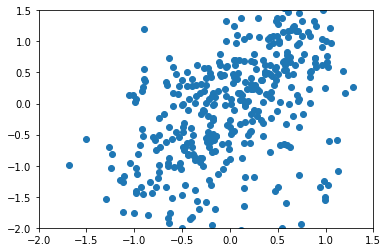

In [118]:
plt.scatter(x = pre, y = truth)
plt.ylim(-2,1.5)
plt.xlim(-2,1.5)

In [138]:
np.sqrt(sum((pre - truth)**2)/len(pre))

array([0.89914661])

In [139]:
pearsonr(pre,truth)

(array([0.50439819]), array([3.86152204e-27]))

In [0]:
X = data1.drop(['lp','Basicity'],axis=1).values
y = data1.lp.values
#X_train,X_test=X[:8000],X[8001:11000],X[11001:]
#y_train,y_test=y[:8000],y[8001:11000],y[11001:]

In [0]:
act_list = ['sigmoid','tanh','softsign']
opt_list = ['adam','RMSprop','Adadelta','SGD','Nadam']

In [10]:
def baseline_model(act,opt,nums):
    model = Sequential()
    model.add(Dense(nums, input_dim = 9, activation = act))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss='mse', optimizer = opt, metrics=['mse']) 
    return model

In [0]:
def generate_model():
    model_list = []
    for act in act_list:
        for opt in opt_list:
            model_list.append(baseline_model(act,opt))
    return model_list

In [0]:
modelList = generate_model()

In [0]:
def cv(df,model):
    kf = KFold(n_splits = 5, random_state = 10, shuffle = False)
    splits = kf.split(df)
    comparision_list = []
    for train_index,test_index in tqdm(splits):
        X_train = df.loc[train_index,'Temp':'V2O5'].values
        X_test = df.loc[test_index,'Temp':'V2O5'].values
        y_train = df.loc[train_index,'lp'].values
        y_test = df.loc[test_index,'lp'].values
        model.fit(X_train, y_train, epochs = 150, batch_size = 20, validation_data = (X_test,y_test),verbose = 0)
        prediction = model.predict(X_test).reshape(len(X_test),)
        comparision = {'prediction':prediction,'truth':y_test}
        comparision_list.append(comparision)
    return comparision_list

In [0]:
def modelsearch(modelList,df):
    result_list = [] 
    for model in tqdm(modelList):
        result = cv(df,model)
        result_list.append(result)
    return result_list

In [0]:
def allsearch():
    final_list = []
    for df in [B1,B2,B3,B4]:
        final = modelsearch(modelList,df)
        final_list.append(final)
    return final_list

In [0]:
B1_result = modelsearch(modelList,B1)